# The One-Lecture Story of Optimization for Machine Learning

**Warning: these lecture notes contain an animation with rapidly moving lines and colors.**

In this lecture, we'll go over a simple example that illustrates some of the important ideas of *optimization for machine learning.* 

*Optimization* is the mathematical study of techniques for finding points at which functions reach their maximum or minimum values. For example, the minimum value of the function $f(x) = x^2$ is the point $x = 0$. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
x = np.linspace(-1, 1, 101)
y = x**2
plt.plot(x,y)
plt.scatter([0], [0], color = "black", zorder = 10)

Optimization techniques are used to obtain similar insights for more complicated functions. 

The reason that we care about optimization in the context of machine learning is that the "training" step of most machine learning methods is nothing other than optimizing a function. As you may remember, the prototypical (supervised) machine learning task has the following form:

> Find a model $f$ from a collection $\mathcal{M}$ of possible models such that $\mathcal{L}(f, X, y)$ is minimized.  

In this problem statement: 

- The *model* $f$ is some kind of function that takes in *predictor data* $X$ and spits out a prediction $\hat{y}$ of the *target* data $y$. 
- $\mathcal{M}$ is a set of all possible models under consideration. Usually this set is parameterized, so that one chooses a model from $\mathcal{M}$ by choosing the values of one or more parameters. 
- $\mathcal{L}$ is a *loss function* that is adapted to our problem scenario. Roughly, the loss function should be designed so that it is small when the model "fits the data" well. What it means to "fit the data" depends on the problem! 

If you're feeling a little unsure about terms like "model" or "predictor data" or "loss function," you might find it helpful to consult [this lecture on basic concepts](https://youtu.be/TOjJcMR053I) ([notes](https://philchodrow.github.io/PIC16A/content/ML/ML_1.jpg)) or [this discussion](https://youtu.be/l-UkQoBlgek) of doing linear regression by hand ([notes](https://nbviewer.jupyter.org/github/PhilChodrow/PIC16A/blob/master/content/ML/ML_2.ipynb)).

We are going to illustrate the ideas in this lecture with our good friend, linear regression. In our standard linear regression setup, we have some predictor data $X$ and some target data $y$, and we aim to approximate: 

$$ y_i \approx \hat{y}_i = \beta_0 + \sum_j \beta_j x_{ij},$$

where $y_i$ is the $i$th value of the target data and $x_{ij}$ is the element in the $i$th row and $j$th column of the predictor data. 

In this setup, a choice of model corresponds to a choice of coefficients $\beta$.  

This model is appropriate when we would like to detect a linear trend in our data, like this: 

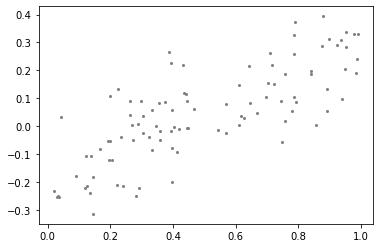

In [2]:
# fake data

n = 100

b0 = -0.2
b1 = 0.5

X = np.random.rand(n)
y = b0 + b1*X + 0.1*np.random.randn(n)
X = X.reshape(n,1)
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)

The problem of drawing a line through these data corresponds to the problem of  minimizing a chosen loss function. We usually use this function: 

$$L(\beta, X, y) = \sum_i \left(\beta_0 + \sum_j \beta_j x_{ij} - y_i\right)^2 = \sum_i (y_i - \hat{y}_i)^2\;.$$

This is the "sum of square residuals" loss, and for those of you comfortable with matrix-vector and norm notations, it can also be written 

$$L(\beta, X, y) = \lVert X\beta - y \rVert^2\;, $$

where we regard $\beta$ as a vector of all the parameters. 

In a recent lecture, we saw that it's possible to perform linear regression using the `np.lstsq()` function. This function allows us to form estimates of $\beta$ by minimizing the least-squares loss. Let's do a quick review for our sample data. 

In this case, we have two coefficients: a slope and an intercept, which I called `b0` and `b1` above. We can do least-squares estimation to get: 

In [3]:
b_hat = np.linalg.lstsq(np.c_[np.ones(n), X], y, rcond = None)[0]
b_hat # true values were b0 = -0.2 and b1 = 0.5

array([-0.17986077,  0.45320329])

*Note*: the use of `np.c_` allowed me to add a column of ones to my predictor data `X`. For math reasons, this allows us to estimate $\beta_0$, which wouldn't otherwise be possible. 

Let's visualize our solution. 

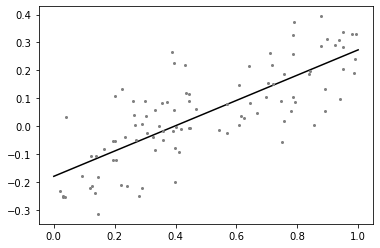

In [4]:
x_space = np.linspace(0, 1, 101)
plt.scatter(X, y, color = "grey", s = 4, zorder = 100)
plt.plot(x_space, b_hat[0] + x_space * b_hat[1], color = "black")

Not bad, that looks like a pretty reasonable linear trend for these data. 

## How did we get here? 

Here's an *algorithmic* question: what does `np.lstsq()` actually do? Or, more generally: 

> How does an optimization algorithm actually *find* a good value for the parameters? 

This is a very big question, and people spend their entire careers studying specific optimization algorithms. In the remainder of this lecture, I'd like to discuss the idea of one specific optimization algorithm, which has become especially important for its applications in machine learning. 

## Stochastic Gradient Descent

*Stochastic gradient descent* (SGD) is a very fancy phrase for a simple very idea. Next time you would like to impress an attractive person at a party, simply say to them: "let us discuss stochastic gradient descent." They will be very impressed indeed. 

Before we talk about any more math, let's look at a picture of what's going on. I'm going to run a lot of code now! We're not going to talk about all the code in this lecture, but we are going to talk about a few of the pieces. 

Sidebar: if you are interested in making animations in Matplotlib, the below is a decent example to get you started. I based the parts of the code that manage the animation on [this example](https://matplotlib.org/stable/gallery/animation/bayes_update.html) in the Matplotlib docs. 

#### Animation Code

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [6]:
class UpdatePlot:
    """
    an update class for a linear regression stochastic gradient descent (SGD)
    animation. Takes instance variables corresponding to plot objects, 
    parameters and estimates, and animation controls. Calling the class
    updates the plot. 
    
    ax: array of 2 axes on which to plot
    b0, b1: floats, true parameters of linear regression
    b0_, b1_: floats, initial estimates of the true parameters
    eps: float, learning rate
    n: int, number of data points
    """
    
    def __init__(self, ax, b0, b1, b0_, b1_, eps = 0.01, n = 100):
        
        # store the axes on which to plot
        self.ax0 = ax[0]
        self.ax1 = ax[1]
        
        # true coefficients
        self.b0 = b0
        self.b1 = b1
        
        # initial coefficient estimates
        self.b0_ = b0_
        self.b1_ = b1_
        
        # number of data points
        self.n = n
        
        # create data
        self.X = np.random.rand(n)
        self.y = self.b0 + self.b1*self.X + 0.1*np.random.randn(n)
        self.X = self.X.reshape(n,1)
        
        # used for plotting lines
        self.x_space = np.linspace(0, 1, 10)
        
        # show data on lefthand plot
        self.ax0.scatter(self.X, self.y, color = "grey", s = 4, zorder = 100)
        
        # prepare animation variables
        self.point = self.ax0.scatter([], [], color = "red", zorder = 200)
        self.line, = self.ax0.plot([], [], 'k-')
        self.loss, = self.ax1.plot([], [], 'k-')
        
        # learning rate
        self.eps = eps
        
        # timesteps and value of loss function
        self.t = []
        self.L = []
        
    def __call__(self, i):
        """
        makes the class callable, resulting in plot updates
        each call performs a single step of SGD and returns
        appropriate artists. i represents the algorithm 
        timestep/animation frame. 
        """
        
        # pick a random point
        j = np.random.randint(self.n)      
        x, y = self.X[j,0], self.y[j]
        
        # update estimates with gradient of loss function evaluated 
        # at that point with respect to the coefficients
        # "this is the math"
        self.b0_ -= self.eps*2*(self.b1_ * x + self.b0_ - y)
        self.b1_ -= self.eps*2*(self.b1_ * x + self.b0_ - y)*x
        
        # evaluate loss function 
        # "this is the other math"
        L = sum((self.b1_*self.X[:,0] + self.b0_ - self.y)**2)
        
        # update lefthand plot with highlight point and new regression
        # line
        self.point.set_offsets([[x, y]])
        self.line.set_data(self.x_space, self.b1_*self.x_space +self.b0_)
        
        # update timestep and loss function
        self.t.append(i)
        self.L.append(L)
        
        # plot loss function
        self.loss.set_data(self.t, self.L)
        
        # return artists
        return [self.point, self.line, self.loss]

In [7]:
# number of algorithm iterations
n_steps = 200

# create plotting background
fig, ax = plt.subplots(1, 2, figsize = (7, 3))

ax[0].set_xlim(0, 1)
ax[0].set_ylim(-0.5, 0.5)

ax[1].set_xlim(0, n_steps)
ax[1].set_ylim(0, 5)
ax[1].grid(True)

ax[0].set(title = "Regression Problem", 
          xlabel = r"$x$",
          ylabel = r"$y$")

ax[1].set(title = "Current Loss",
          xlabel = "Iteration",
          ylabel = r"$\mathcal{L}$")

plt.tight_layout()

# create the plot updater
ud = UpdatePlot(ax, -0.2, 0.5, 0, 0, eps = 0.1, n = 100)
anim = FuncAnimation(fig, ud, frames=n_steps, interval=200, blit=True)

# to save as gif
# anim.save('regression_sgd.gif',  fps=20, dpi = 200) 

# to interactively display in notebook
plt.close() # prevents plot from showing twice
HTML(anim.to_jshtml()) 

What's going on here? 

On the **lefthand side**, we can see a sequence of possible linear models, which change over time. In each step of the algorithm:

1. We select a random data point (red highlight). 
2. We ask that point what its opinion is about the best value of the parameters. 
3. We then push the parameters a little bit in the direction of that point's opinion. 

On the righthand side, we can see the loss function from above, that measures the quality of the fit. Smaller values are better, and we can see that the loss function does indeed tend to decrease over time. That said, we can also see little spikes where the loss function actually increases. This is due to "weird" points, who have opinions about the coefficients that deviate significantly from the average. Often, these are statistical outliers.  

A bit more mathematically, at each timestep, we pick a random point $j$ and then do this: 

$$ \hat{\beta}_t = \hat{\beta}_{t-1} - \epsilon \nabla_{\hat{\beta}} \ell(\hat{\beta}, x_j, y_j)$$

If you're familiar with multivariable calculus, the term $\nabla_{\hat{\beta}} \ell(\hat{\beta}, x_j, y_j)$ is the gradient with respect to $\hat{\beta}$ of the single-point loss function 

$$\ell(\hat{\beta}, x_j, y_j) = \left(\hat{\beta}_0 + \hat{\beta}_1 x_j - y_j\right)^2\;.$$

In this case, it's possible to calculate the gradient directly: 

$$
\nabla_\hat{\beta} \ell(\hat{\beta}, x_j, y_j) = 
2 (\hat{\beta}_0 + \hat{\beta}_1x_j - y_j)
\left(\begin{matrix}
1 \\ x_j
\end{matrix}\right)
$$

The first component corresponds to $\hat{\beta}_0$, and the second component corresponds to $\hat{\beta}_1$. 

If you're not familiar with multivariable calculus, it's ok to think of $\nabla_{\hat{\beta}} \ell(\hat{\beta}, x_j, y_j)$ as expressing point $j$'s "personal suggestion" about how to improve the current values of $\hat{\beta}_0$ and $\hat{\beta}_1$. 

Now we're ready to unpack the phrase "stochastic gradient descent." 

- **Stochastic**: at each stage, we pick a random (stochastic) data point. 
- **Gradient**: we compute that point's "opinion" about the parameters by using the gradient. 
- **Descent**: the loss function usually goes down ("descends") over time. 

Stochastic gradient descent is commonly used in many machine learning models, and is extremely popular in deep learning specifically. When we "train" or "fit" TensorFlow models, we'll often be using a relative of SGD under the hood. 

## Implementing SGD for Linear Regression

Let's now implement the SGD algorithm for linear algebra. The code in this section is the same code used to produce the animation above. 

In [8]:
b0_, b1_ = 0, 0 # initial estimates of the parameters

# "learning rate", controls how much we are allowed to 
# change the estimates in each iteration
eps = 0.1 

n_steps = 1000
for t in range(n_steps):
    
    # pick a random point, 
    # including predictor and target 
    j = np.random.randint(n)      
    x_current, y_current = X[j,0], y[j]
    
    # compute gradient ∇l
    g0 = 2*(b1_ * x_current + b0_ - y_current)
    g1 = 2*(b1_ * x_current + b0_ - y_current) * x_current
    
    # update parameter estimates using gradient
    b0_ -= eps * g0
    b1_ -= eps * g1
    
    # compute current loss
    L = sum((b1_*X[:,0] + b0_ - y)**2)
    
    # print current state
    if t % 50 == 0:
        print(f"Step {t}".ljust(10), end = "")
        print(f"L = {round(L, 3)}".ljust(12), end = "")
        print(f"b0 = {round(b0_, 3)}".ljust(15), end = "")
        print(f"b1 = {round(b1_, 3)}".ljust(15), end = "")
        print("")

Step 0    L = 2.625   b0 = 0.026     b1 = 0.023     
Step 50   L = 1.732   b0 = -0.075    b1 = 0.192     
Step 100  L = 1.359   b0 = -0.081    b1 = 0.295     
Step 150  L = 1.159   b0 = -0.149    b1 = 0.38      
Step 200  L = 1.185   b0 = -0.197    b1 = 0.435     
Step 250  L = 1.191   b0 = -0.217    b1 = 0.474     
Step 300  L = 1.564   b0 = -0.117    b1 = 0.462     
Step 350  L = 1.173   b0 = -0.214    b1 = 0.474     
Step 400  L = 1.342   b0 = -0.229    b1 = 0.456     
Step 450  L = 1.114   b0 = -0.183    b1 = 0.466     
Step 500  L = 1.2     b0 = -0.171    b1 = 0.491     
Step 550  L = 1.195   b0 = -0.162    b1 = 0.475     
Step 600  L = 1.327   b0 = -0.157    b1 = 0.497     
Step 650  L = 1.191   b0 = -0.205    b1 = 0.448     
Step 700  L = 1.203   b0 = -0.214    b1 = 0.461     
Step 750  L = 1.25    b0 = -0.191    b1 = 0.406     
Step 800  L = 2.004   b0 = -0.251    b1 = 0.407     
Step 850  L = 1.135   b0 = -0.167    b1 = 0.41      
Step 900  L = 1.123   b0 = -0.165    b1 = 0.41

That's it for this lecture! In future lectures, we'll take our understanding of linear algebra and optimization into an extended study of practical machine learning via neural networks. 